In [57]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt
import random

tf.random.set_seed(2022)
random.seed(2022)
np.random.seed(2022)

# DataSet

In [58]:
x_train = np.zeros((0, 64, 64, 3))
for i in range(8):
    x_train = np.append(x_train, np.load(f"dataset/dataset-{i}.npy"), axis=0)
x_train.shape

(1680, 64, 64, 3)

In [59]:
dataset = tf.data.Dataset.from_tensor_slices((x_train[:30]))
dataset = dataset.batch(10)

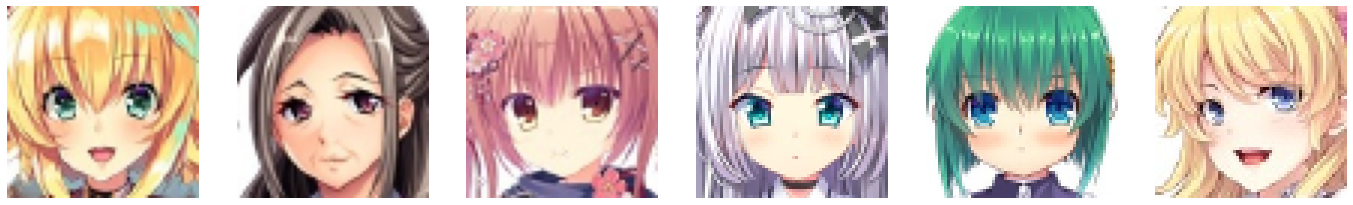

In [75]:
plt.subplots(figsize=(4*6, 4))
for i in range(6):
    ax = plt.subplot(1, 6, i+1)
    ax.axis('off')
    ax.imshow(random.choice(x_train))

In [76]:
def downsample(channels, kernel, stride=1, keep=True, batch=True):
    seq = keras.Sequential()

    initializer = tf.random_normal_initializer(0, 0.075)

    seq.add(layers.Conv2D(
        channels,
        kernel,
        strides=stride,
        padding='same' if keep else 'valid',
        kernel_initializer=initializer,
        use_bias=not batch)
    )
    if batch:
        seq.add(layers.BatchNormalization())
    seq.add(layers.LeakyReLU(0.2))

    return seq

In [77]:
def upsample(channels, kernel, stride=1, keep=True, drop=False):
    seq = keras.Sequential()

    initializer = tf.random_normal_initializer(0, 0.075)

    seq.add(layers.Conv2DTranspose(
        channels,
        kernel,
        strides=stride,
        padding='same' if keep else 'valid',
        kernel_initializer=initializer,
        use_bias=False)
    )
    seq.add(layers.BatchNormalization())
    
    if drop:
        seq.add(layers.Dropout(0.5))

    seq.add(layers.LeakyReLU(0.02))

    return seq

In [78]:
def Discriminator():
    input_ = layers.Input((64, 64, 3))

    downsamples = [
        downsample(16, 3, batch=False),
        downsample(32, 3, keep=False),
        downsample(64, 3, keep=False),
        downsample(128, 3, keep=False),
        downsample(256, 3, stride=2),
        downsample(512, 3, stride=2),
        downsample(512, 2, keep=False)
    ]

    last = layers.Conv2D(
        1,
        3,
        padding='same',
        activation='sigmoid')

    x = input_

    for down in downsamples:
        x = down(x)

    x = last(x)

    return keras.Model(inputs=input_, outputs=x)

In [92]:
def Generator():
    input_ = layers.Input(128)

    denses = [
        layers.Dense(128, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
    ]

    reshaper = layers.Reshape((1, 1, 512))

    upsamples = [
        upsample(512, 3, stride=2, drop=True),
        upsample(512, 3, stride=2, drop=True),
        upsample(256, 3, keep=False, stride=2, drop=True),
        upsample(128, 3, stride=2),
        upsample(64, 4, stride=3),
        upsample(32, 5, keep=False),
        upsample(16, 4, keep=False),
        upsample(16, 3, keep=False)
    ]

    last = layers.Conv2DTranspose(
        3,
        2,
        activation='sigmoid')

    x = input_

    for lay in denses:
        x = lay(x)
    
    x = reshaper(x)

    for up in upsamples:
        x = up(x)
    
    x = last(x)

    return keras.Model(inputs=input_, outputs=x)

In [93]:
gen = Generator()
disc = Discriminator()

In [12]:
gen.load_weights("gen.h5")
disc.load_weights("disc.h5")

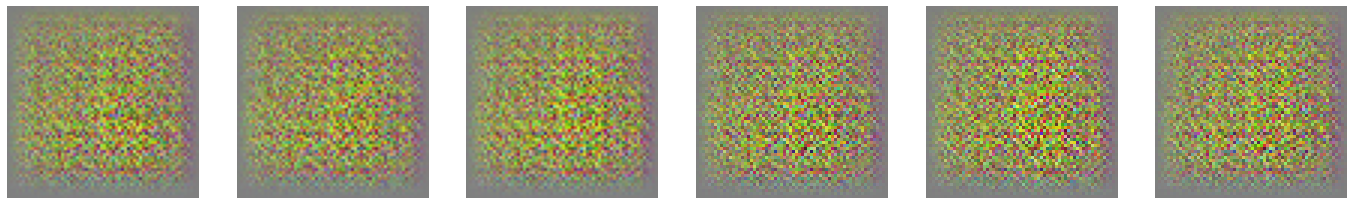

In [99]:
def generate_images():
    fake = gen.predict(tf.random.uniform((6, 128)), verbose=0)
    plt.subplots(figsize=(4*6, 4))
    for i in range(6):
        ax = plt.subplot(1, 6, i+1)
        ax.axis('off')
        ax.imshow(fake[i])
    plt.show()

generate_images()

In [14]:
loss_object = tf.losses.BinaryCrossentropy(from_logits = False)

In [94]:
def discriminator_loss(disc_real_output, disc_gen_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    gen_loss = loss_object(tf.zeros_like(disc_gen_output), disc_gen_output)

    return real_loss + gen_loss

def generator_loss(disc_gen_output):
    gen_loss = loss_object(tf.ones_like(disc_gen_output), disc_gen_output)
    return gen_loss

In [95]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [100]:
def train_step(real):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        x = tf.random.uniform((len(real), 128))

        fake = gen(x, training=True)
        o_fake = disc(fake, training=True)
        o_real = disc(real, training=True)

        disc_loss = discriminator_loss(o_real, o_fake)
        gen_loss = generator_loss(o_fake)

        gen_grads = gen_tape.gradient(gen_loss, gen.trainable_variables)
        disc_grads = disc_tape.gradient(disc_loss, disc.trainable_variables)

        generator_optimizer.apply_gradients(zip(gen_grads, gen.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(disc_grads, disc.trainable_variables))

In [101]:
def train(dataset, epochs):
    for epoch in range(epochs):
        for i, data in enumerate(dataset):
            print(f"Epoch: {epoch+1} - {i+1}/{len(dataset)}")
            train_step(data)
        generate_images()

In [ ]:
train(dataset, 10)

In [81]:
gen.save_weights("gen.h5")
disc.save_weights("disc.h5")